<a href="https://www.kaggle.com/code/mustafagull/car-damage-detection-g-kayhelvac-mustafaugurgul?scriptVersionId=166464923" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Veri hazırlama**

Bu aşamada verisetimiz sisteme dahil edilir ayrıca modelin hasarsız araçlarıda tanıyabilmesi için hasarsız araçların bulunduğu stanford car verisetinden görsellerde verisetimize dahil edilmiştir.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from PIL import Image


input_folder_path = "/kaggle/input/cardamagedataset/CarDD_release/CarDD_SOD/CarDD-TR/CarDD-TR-Image"
target_folder_path = "/kaggle/input/cardamagedataset/CarDD_release/CarDD_SOD/CarDD-TR/CarDD-TR-Mask"

input_image_filenames = sorted(os.listdir(input_folder_path))
target_image_filenames = sorted(os.listdir(target_folder_path))

input_image_paths = [os.path.join(input_folder_path, filename) for filename in input_image_filenames]
target_image_paths = [os.path.join(target_folder_path, filename) for filename in target_image_filenames]

if len(input_image_paths) != len(target_image_paths):
    raise ValueError("Girdi ve hedef görüntü sayıları aynı olmalıdır.")
    

print(input_image_paths[520])
print(target_image_paths[520])


/kaggle/input/cardamagedataset/CarDD_release/CarDD_SOD/CarDD-TR/CarDD-TR-Image/000745.jpg
/kaggle/input/cardamagedataset/CarDD_release/CarDD_SOD/CarDD-TR/CarDD-TR-Mask/000745.png


In [2]:
import os
from PIL import Image
import shutil

shutil.copytree("/kaggle/input/stanford-cars-dataset/cars_train/cars_train","kaggle/working/data")

input_folder_path = "/kaggle/working/kaggle/working/data/"

image_filenames = sorted(os.listdir(input_folder_path))[:3000]


input_image_paths_2 = [os.path.join(input_folder_path, filename) for filename in image_filenames]

min_width = 512
min_height = 512

filtered_image_paths = []

prefix = "!" 

for filename in image_filenames:
    file_path = os.path.join(input_folder_path, filename)
    
    with Image.open(file_path) as img:
        width, height = img.size
        if width >= min_width and height >= min_height:
            new_filename = prefix + filename
            new_file_path = os.path.join(input_folder_path, new_filename)
            
            os.rename(file_path, new_file_path)
            filtered_image_paths.append(new_file_path)

print(len(filtered_image_paths))



823


# **Ön İşleme**

Bu aşamada verisetimiz tensorflow modelimizin algılayabileceği türe dönüştürürmüş, görsel boyurları 512,512 olacak şekilde ayarlanmış, görsellere rastgele döndürme işlemi uygulanmış ve %85 train %5 validation %10 train olacak şekilde setlerimiz oluşturulmuştur.


In [3]:
batch_size = 16

def load_and_preprocess_image(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3,expand_animations = False)  # Adjust channels as needed
    image = tf.image.resize(image, [256, 256]) 
    image = image / 255.0 
    return image

def load_and_preprocess_mask(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1,expand_animations = False)  # Adjust channels as needed
    image = tf.image.resize(image, [256, 256])  
    image = image / 255.0 
    return image

def load_and_preprocess_image_nondamaged(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3,expand_animations = False)  # Adjust channels as needed
    image = tf.image.random_crop(value=image, size=(256, 256 , 3))    
    image = tf.image.resize(image, [256, 256]) 

    image = image / 255.0 
    return image

def load_and_preprocess_image_nondamaged_mask(image_path):

    mask = tf.zeros(shape=(256, 256, 1), dtype=tf.float32)

    return mask


def load_and_preprocess_image_and_mask(image,mask):

    random_angle = tf.random.uniform(shape=[], minval=0, maxval=8)

    combined_tensor = tf.concat([image, mask], axis=-1)

    combined_tensor = tf.image.rot90(combined_tensor, k=tf.cast(random_angle / (3.14159265359 / 2), tf.int32))

    image, mask = tf.split(combined_tensor, num_or_size_splits=[3, 1], axis=-1)

    return image,mask


input_dataset = tf.data.Dataset.from_tensor_slices(input_image_paths)
target_dataset = tf.data.Dataset.from_tensor_slices(target_image_paths)
nondamaged_dataset = tf.data.Dataset.from_tensor_slices(filtered_image_paths)
nondamaged_dataset_mask = tf.data.Dataset.from_tensor_slices(filtered_image_paths)


input_dataset = input_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
target_dataset = target_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
nondamaged_dataset = nondamaged_dataset.map(load_and_preprocess_image_nondamaged, num_parallel_calls=tf.data.experimental.AUTOTUNE)
nondamaged_mask_dataset = nondamaged_dataset.map(load_and_preprocess_image_nondamaged_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_dataset = nondamaged_dataset.concatenate(input_dataset)
target_dataset= nondamaged_mask_dataset.concatenate(target_dataset)


img2img_dataset = tf.data.Dataset.zip((input_dataset, target_dataset))

img2img_dataset = img2img_dataset.shuffle(6400)


repeat_size = 3
img2img_dataset = img2img_dataset.repeat(repeat_size)

img2img_dataset = img2img_dataset.map(load_and_preprocess_image_and_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

img2img_dataset = img2img_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print(len(img2img_dataset))
# Split into training, validation, and test sets
train_size = int(0.85 * len(img2img_dataset))
val_size = int(0.05 * len(img2img_dataset))
test_size = len(img2img_dataset) - train_size - val_size

print(img2img_dataset)

train_dataset = img2img_dataset.take(train_size).batch(batch_size)
val_dataset = img2img_dataset.skip(train_size).take(val_size).batch(batch_size)
test_dataset = img2img_dataset.skip(train_size + val_size).batch(batch_size)


2024-01-10 02:50:56.271661: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:50:56.271771: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:50:56.271859: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:50:56.271936: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:50:56.272006: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:50:56.272203: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:50:56.272350: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

10917
<_PrefetchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>


# **Model Oluşturma**

Bu aşamada CNN (Convolutional Neural Network) katmanları kullanılarak U-net mimarisi ile bir tensorflow modeli oluşturulmu, özel bir loss fonksiyonu oluşturulmuş ve modelin diğer parametreleri ayarlanmıştır.

In [4]:
def get_model(img_size):
    inputs = keras.Input(shape=img_size)
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)       
    
    outputs = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(c9)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# **Eğitim**
Bu aşamada modeli eğitmek için kullanacaığımız strateji-cihaz (TPU,GPU,CPU) seçilecek ve eğitim başlatılacaktır.

In [5]:
tf.get_logger().setLevel('ERROR')

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    
from keras import backend as K


def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

with strategy.scope():
    model = get_model(img_size=(256, 256, 3))
    print(model.summary())
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,verbose=1,restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[callback]
)

Running on TPU  


2024-01-10 02:51:01.318731: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:01.318867: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

2024-01-10 02:51:05.926190: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:05.944997: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:05.965885: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:05.985046: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:06.003317: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:06.021131: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:06.043775: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/100


2024-01-10 02:51:11.668225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-01-10 02:51:20.153255: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:20.156510: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:20.157613: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:20.159301: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:20.160570: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:20.161025: E ./tensorflow/compiler/xla/stream_executor/st

  3/580 [..............................] - ETA: 34s - loss: 0.6587 - accuracy: 0.7434   

2024-01-10 02:51:52.046912: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:52.047177: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:52.047283: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:52.047387: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:52.047501: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:52.047594: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:52.047702: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  9/580 [..............................] - ETA: 33s - loss: 0.6078 - accuracy: 0.7644

2024-01-10 02:51:52.404874: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 33/580 [>.............................] - ETA: 29s - loss: 0.5551 - accuracy: 0.7952

2024-01-10 02:51:53.633195: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 75/580 [==>...........................] - ETA: 25s - loss: 0.5416 - accuracy: 0.7919

2024-01-10 02:51:55.756165: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


101/580 [====>.........................] - ETA: 24s - loss: 0.5279 - accuracy: 0.7970

2024-01-10 02:51:57.058309: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-10 02:51:57.058629: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


296/580 [==============>...............] - ETA: 14s - loss: 0.4878 - accuracy: 0.8000

2024-01-10 02:52:07.055738: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


580/580 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8052

2024-01-10 02:52:22.258025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


580/580 [==============================] - 99s 92ms/step - loss: 0.4599 - accuracy: 0.8052 - val_loss: 0.4001 - val_accuracy: 0.8279
Epoch 2/100
  5/580 [..............................] - ETA: 31s - loss: 0.3728 - accuracy: 0.8561

2024-01-10 02:52:51.271439: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


580/580 [==============================] - 46s 70ms/step - loss: 0.4015 - accuracy: 0.8288 - val_loss: 0.3884 - val_accuracy: 0.8331
Epoch 3/100
580/580 [==============================] - 45s 68ms/step - loss: 0.3666 - accuracy: 0.8428 - val_loss: 0.3418 - val_accuracy: 0.8519
Epoch 4/100
580/580 [==============================] - 45s 69ms/step - loss: 0.3453 - accuracy: 0.8516 - val_loss: 0.3241 - val_accuracy: 0.8613
Epoch 5/100
580/580 [==============================] - 45s 68ms/step - loss: 0.3324 - accuracy: 0.8561 - val_loss: 0.3281 - val_accuracy: 0.8511
Epoch 6/100
580/580 [==============================] - 45s 68ms/step - loss: 0.3184 - accuracy: 0.8627 - val_loss: 0.3106 - val_accuracy: 0.8639
Epoch 7/100
580/580 [==============================] - 46s 69ms/step - loss: 0.3113 - accuracy: 0.8665 - val_loss: 0.3095 - val_accuracy: 0.8656
Epoch 8/100
580/580 [==============================] - 46s 70ms/step - loss: 0.2980 - accuracy: 0.8716 - val_loss: 0.2788 - val_accuracy: 0.88

Model Performansını Görselleştir

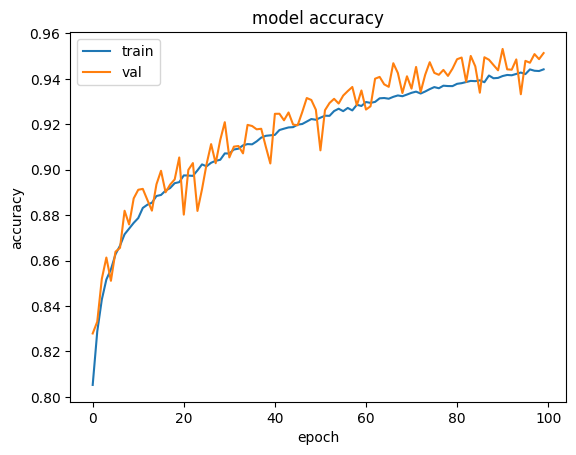

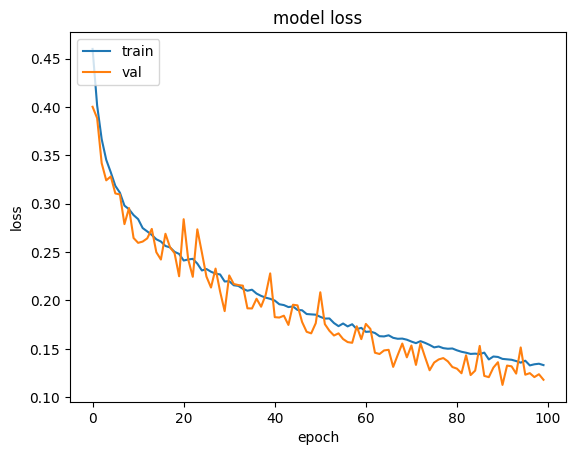

In [6]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Test**
Bu aşamada eğittiğimiz modeli test ediyoruz

In [7]:
results = model.evaluate(test_dataset)
print(f"Model test veri setinde %{results[1]*100:.2f} oranında başarı sağlamıştır.")

69/69 [==============================] - 13s 21ms/step - loss: 0.1116 - accuracy: 0.9540
Model test veri setinde %95.40 oranında başarı sağlamıştır.


test verilerimizi görselleştiriyoruz

2024-01-10 04:09:28.644293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 11s 11s/step
(16, 256, 256, 1)


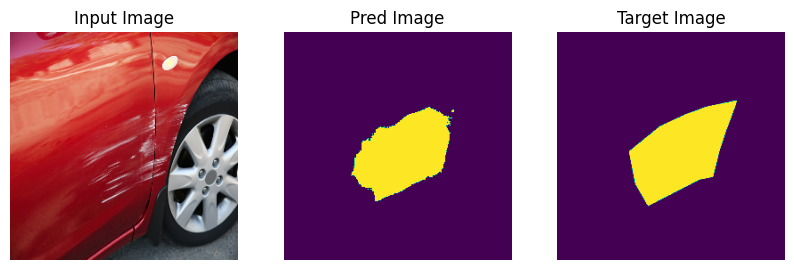

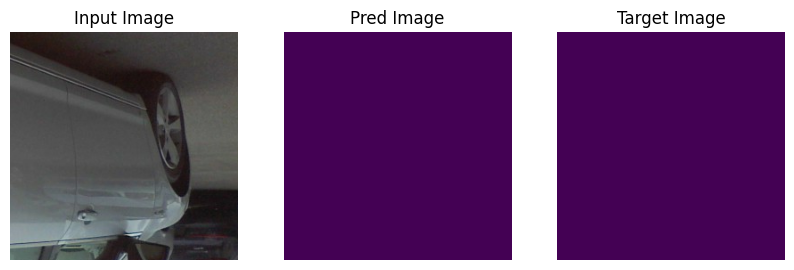

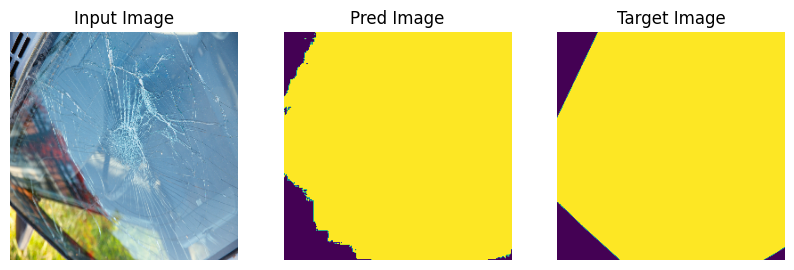

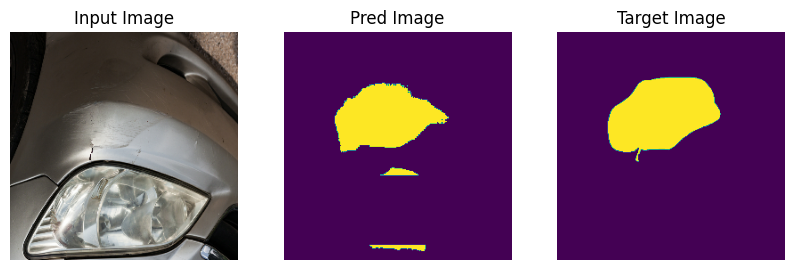

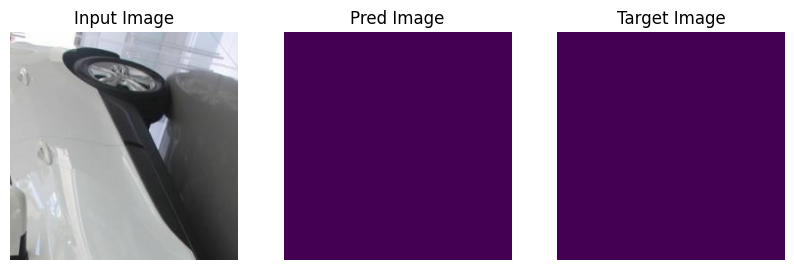

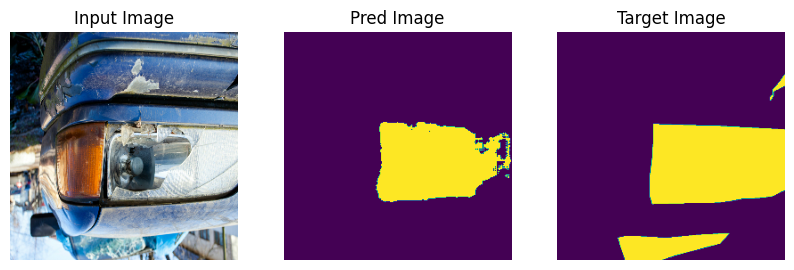

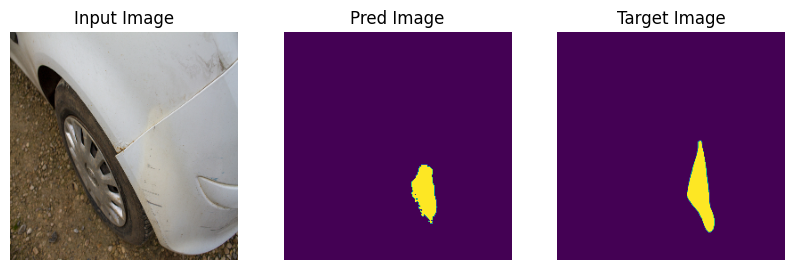

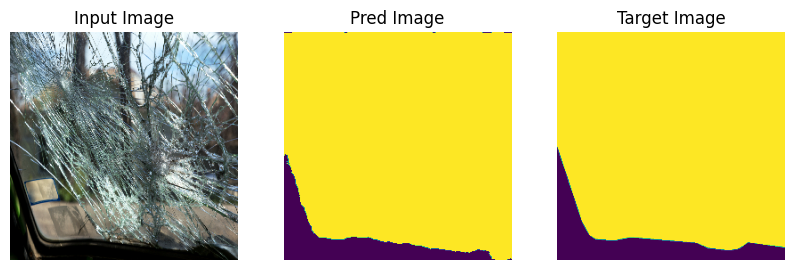

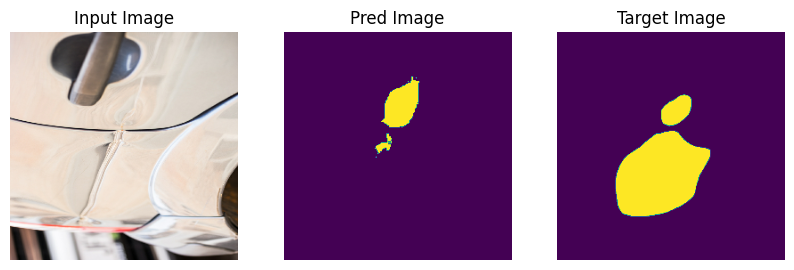

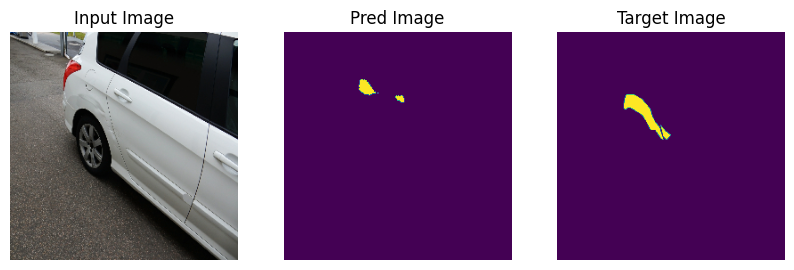

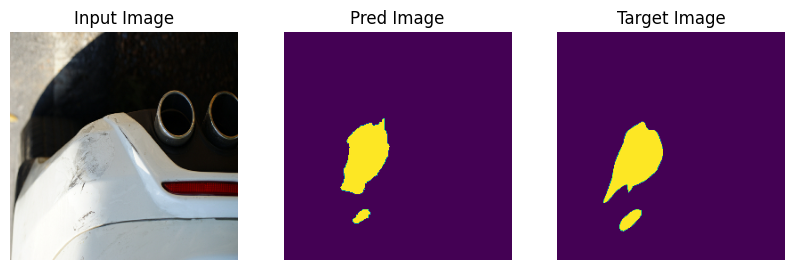

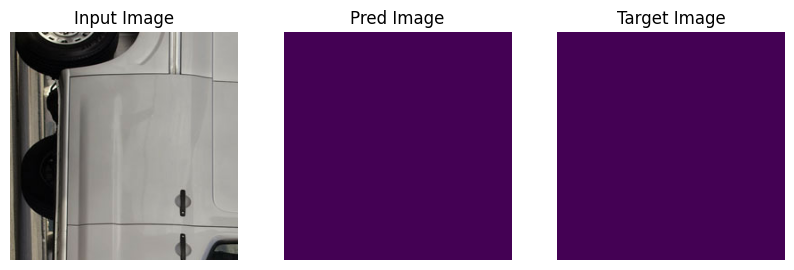

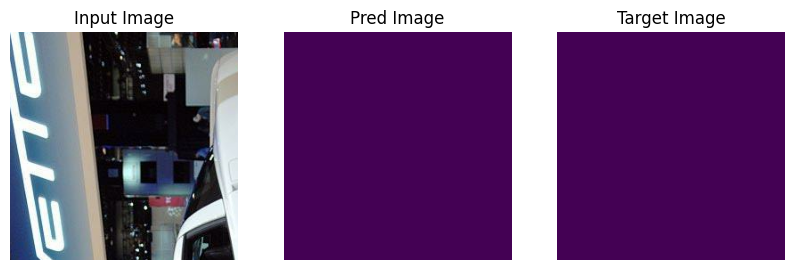

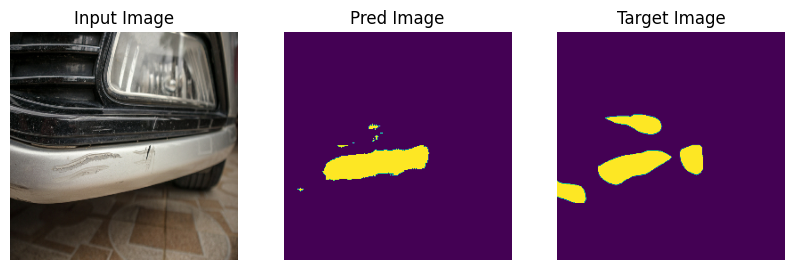

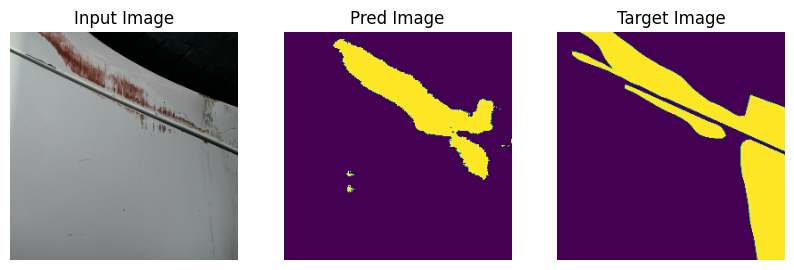

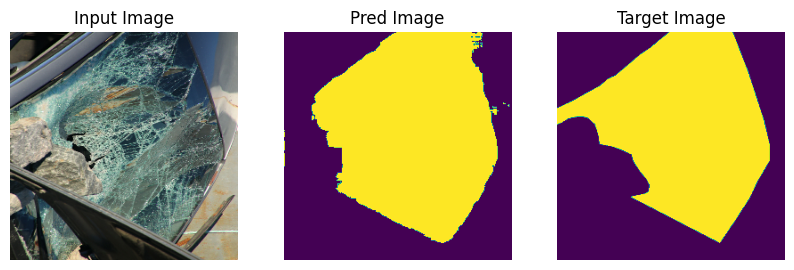

In [8]:
from sklearn.metrics import confusion_matrix

iterator = iter(test_dataset)
import numpy as np

try:
    input_image_path, target_image_path = next(iterator)

    test_preds = model.predict(input_image_path)
    print(test_preds.shape)
    preds_test_thresh = (test_preds >= 0.50).astype(np.uint8) 

    for i in range(batch_size):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(input_image_path[i].numpy())  # TensorFlow tensörünü numpy dizisine çevirin
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Pred Image")
        plt.imshow(preds_test_thresh[i])  # TensorFlow tensörünü numpy dizisine çevirin
        plt.axis('off')    

        plt.subplot(1, 3, 3)
        plt.title("Target Image")
        plt.imshow(target_image_path[i].numpy())  # TensorFlow tensörünü numpy dizisine çevirin
        plt.axis('off')

        plt.show()

except StopIteration:
    print("Veri kümesi sona erdi.")

    


Confusion Matrisi hesaplıyoruz


In [9]:
iterator = iter(test_dataset)

tn, fp, fn, tp = 0,0,0,0
try:
    for i in range(len(test_dataset)):
    
        input_image_path, target_image_path = next(iterator)

        test_preds = model.predict(input_image_path,verbose=0)
        preds_test_thresh = (test_preds >= 0.50).astype(np.uint8) 

        target_test_thresh = (target_image_path.numpy() >= 0.50).astype(np.uint8) 

        tn_temp, fp_temp, fn_temp, tp_temp = confusion_matrix(target_test_thresh.flatten().tolist(), preds_test_thresh.flatten().tolist()).ravel()
        tn+=tn_temp
        fp+=fp_temp
        fn+=fn_temp
        tp+=tp_temp
        break
    print("\thasarlı","hasarsız")
    print("hasarlı",tn, fp)
    print("hasarsız",fn, tp)
        
except StopIteration:
    print("Veri kümesi sona erdi.")

	hasarlı hasarsız
hasarlı 901223 17900
hasarsız 37312 92141


# **Modelimizi Kaydediyoruz**

In [10]:
model.save("keras.model")
